In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")


Using Device: cuda


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

# 1. Device Configuration (Utilizing your RTX 4060)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

# 2. Data Loading & Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# 3. The CNN Model (Standard Baseline)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.classifier(x)
        return x

Using Device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import math

# 4. Custom Optimizer: Adam with Gradient Centralization (AdamGC)
class AdamGC(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(AdamGC, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                
                # --- THE CUSTOM TWEAK: GRADIENT CENTRALIZATION ---
                # Only apply to Conv/Linear layers (dim > 1)
                if grad.dim() > 1:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                # -------------------------------------------------

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                step_size = group['lr'] / bias_correction1

                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [4]:
# 5. The Training Loop Function
def train_model(model, optimizer, criterion, epochs=10):
    model.to(device)
    history = {'loss': [], 'accuracy': []}
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.2f}%")
        
    print(f"Training completed in {(time.time() - start_time):.2f} seconds\n")
    return history

# 6. Run the Experiment!
criterion = nn.CrossEntropyLoss()

print("========== RUNNING BASELINE: STANDARD ADAM ==========")
model_baseline = SimpleCNN()
optimizer_adam = optim.Adam(model_baseline.parameters(), lr=0.001)
history_adam = train_model(model_baseline, optimizer_adam, criterion, epochs=10)

print("========== RUNNING CUSTOM: ADAM WITH GC ==========")
model_custom = SimpleCNN()
optimizer_custom = AdamGC(model_custom.parameters(), lr=0.001)
history_custom = train_model(model_custom, optimizer_custom, criterion, epochs=10)

========== RUNNING BASELINE: STANDARD ADAM ==========
Epoch [1/10] - Loss: 1.5623 - Acc: 42.58%
Epoch [2/10] - Loss: 1.2197 - Acc: 56.07%
Epoch [3/10] - Loss: 1.0839 - Acc: 61.40%
Epoch [4/10] - Loss: 1.0054 - Acc: 64.57%
Epoch [5/10] - Loss: 0.9462 - Acc: 66.71%
Epoch [6/10] - Loss: 0.9059 - Acc: 68.25%
Epoch [7/10] - Loss: 0.8602 - Acc: 70.06%
Epoch [8/10] - Loss: 0.8305 - Acc: 71.00%
Epoch [9/10] - Loss: 0.8021 - Acc: 72.02%
Epoch [10/10] - Loss: 0.7682 - Acc: 73.38%
Training completed in 102.07 seconds

========== RUNNING CUSTOM: ADAM WITH GC ==========
Epoch [1/10] - Loss: 1.3926 - Acc: 50.13%
Epoch [2/10] - Loss: 1.0800 - Acc: 61.72%
Epoch [3/10] - Loss: 0.9644 - Acc: 66.21%
Epoch [4/10] - Loss: 0.8873 - Acc: 68.86%
Epoch [5/10] - Loss: 0.8382 - Acc: 70.76%
Epoch [6/10] - Loss: 0.7958 - Acc: 72.30%
Epoch [7/10] - Loss: 0.7701 - Acc: 73.15%
Epoch [8/10] - Loss: 0.7454 - Acc: 74.10%
Epoch [9/10] - Loss: 0.7196 - Acc: 75.05%
Epoch [10/10] - Loss: 0.6980 - Acc: 75.62%
Training comple

Generating comparative plots for the research paper...


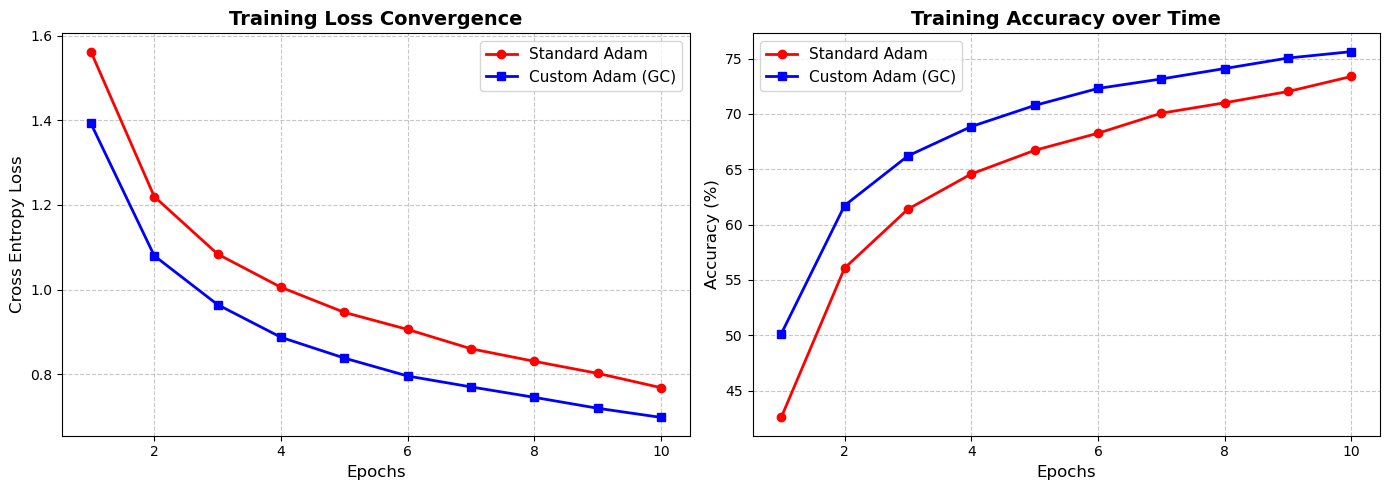

In [5]:
import matplotlib.pyplot as plt

def plot_experiment_results(history_baseline, history_custom, epochs=10):
    # Set up a wide, professional-looking figure
    plt.figure(figsize=(14, 5))
    
    # Create an array for the X-axis (Epochs 1 to 10)
    epoch_range = range(1, epochs + 1)

    # ==========================================
    # PLOT 1: Training Loss (Lower is better)
    # ==========================================
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, history_baseline['loss'], 'r-o', label='Standard Adam', linewidth=2)
    plt.plot(epoch_range, history_custom['loss'], 'b-s', label='Custom Adam (GC)', linewidth=2)
    
    plt.title('Training Loss Convergence', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Cross Entropy Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11)

    # ==========================================
    # PLOT 2: Training Accuracy (Higher is better)
    # ==========================================
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, history_baseline['accuracy'], 'r-o', label='Standard Adam', linewidth=2)
    plt.plot(epoch_range, history_custom['accuracy'], 'b-s', label='Custom Adam (GC)', linewidth=2)
    
    plt.title('Training Accuracy over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=11)

    # Adjust layout so they don't overlap and display the plot
    plt.tight_layout()
    plt.savefig('optimizer_comparison_cifar10.png', dpi=300) # Saves a high-res copy for your paper!
    plt.show()

# --- Call the function after your training loops finish ---
print("Generating comparative plots for the research paper...")
plot_experiment_results(history_adam, history_custom, epochs=10)